In [1]:
import bte
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import adjusted_rand_score as ari
from scipy.stats import percentileofscore as pos
import matplotlib.pyplot as plt

We can load our Nextstrain JSON as MATs directly.

In [2]:
chikv = bte.MATree(json_file="CHIKV_5.0.json")
vee = bte.MATree(json_file="VEE.json")
vee

MATree object with 165 leaves.

First, we examine CHIKV.

In [3]:
chikv_lin = pd.read_csv("CHIKV_metadata_full.tsv",sep='\t')
chikv_lin

,strain,lineage,GRI Lineage Level 0,GRI Lineage Level 1,GRI Lineage Level 2,GRI Lineage Level 3,GRI Lineage Level 4,GRI Lineage Level 5,GRI Lineage Level 6,GRI Lineage Level 7,GRI Lineage Level 8
0,HM045816.1,WA,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned
1,HM045785.1,WA,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned
2,HM045815.1,WA,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned
3,HM045786.1,WA,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned
4,MK028837.1,WA,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned,not_assigned
...,...,...,...,...,...,...,...,...,...,...,...
1393,KY704001.1,AUL-Am,A,A.0,A.0.0,A.0.0.1,A.0.0.1.0,A.0.0.1.0,A.0.0.1.0,A.0.0.1.0,A.0.0.1.0
1394,KY703934.1,AUL-Am,A,A.0,A.0.0,A.0.0.1,A.0.0.1.0,A.0.0.1.0.0,A.0.0.1.0.0.1,A.0.0.1.0.0.1,A.0.0.1.0.0.1
1395,KY703994.1,AUL-Am,A,A.0,A.0.0,A.0.0.1,A.0.0.1.0,A.0.0.1.0.0,A.0.0.1.0.0.1,A.0.0.1.0.0.1,A.0.0.1.0.0.1
1396,KY703956.1,AUL-Am,A,A.0,A.0.0,A.0.0.1,A.0.0.1.0,A.0.0.1.0.0,A.0.0.1.0.0.0,A.0.0.1.0.0.0,A.0.0.1.0.0.0


This metadata set has the levels of annotation split out by column already.

In [4]:
levels = [c for c in chikv_lin.columns if c not in ['strain','lineage']]
levels

['GRI Lineage Level 0',
 'GRI Lineage Level 1',
 'GRI Lineage Level 2',
 'GRI Lineage Level 3',
 'GRI Lineage Level 4',
 'GRI Lineage Level 5',
 'GRI Lineage Level 6',
 'GRI Lineage Level 7',
 'GRI Lineage Level 8']

Text(0.5, 1.0, 'ChikV Level ARI')

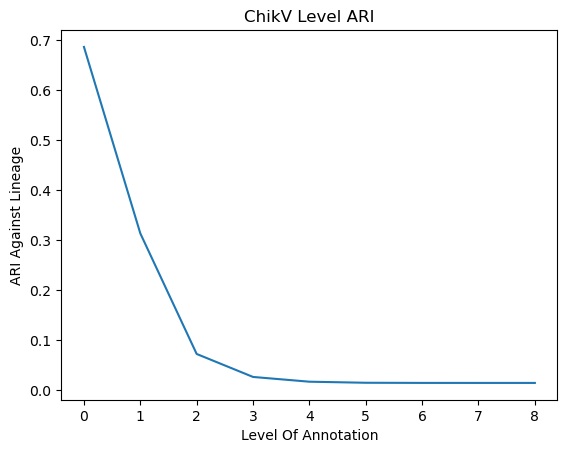

In [5]:
x = []
y = []
for i,l in enumerate(levels):
    x.append(i)
    y.append(ari(chikv_lin['lineage'],chikv_lin[l]))
sns.lineplot(x=x,y=y)
plt.ylabel("ARI Against Lineage")
plt.xlabel("Level Of Annotation")
plt.title("ChikV Level ARI")

Level 0 has the best alignment with the current nomenclature. We proceed to evaluate it statistically by generating a distribution of adjusted Rand scores that represent the values we would expect if that many lineages were assigned to nodes completely at random. 

In [6]:
def sample_ari(t, mdf, perms = 10000, truename='lineage', target='GRI Lineage Level 0'):
    lineage_count = mdf[target].nunique()
    node_names = []
    for n in t.depth_first_expansion():
        if not n.is_leaf():
            node_names.append(n.id)
    aris = []
    for p in range(perms):
        lingroups = []
        choices = set(np.random.choice(node_names,size=lineage_count,replace=False))
        for s in mdf.strain:
            assigned = False
            for anc in t.rsearch(s):
                if anc.id in choices:
                    assigned = True
                    lingroups.append(anc.id)
                    break
            if not assigned:
                lingroups.append('not assigned')
        ari_v = ari(mdf[truename],lingroups)
        aris.append(ari_v)
    return aris

null = sample_ari(chikv,chikv_lin,truename='lineage',target='GRI Lineage Level 0')

ARI: 0.6857502230620075 p-value:  0.018400000000000083


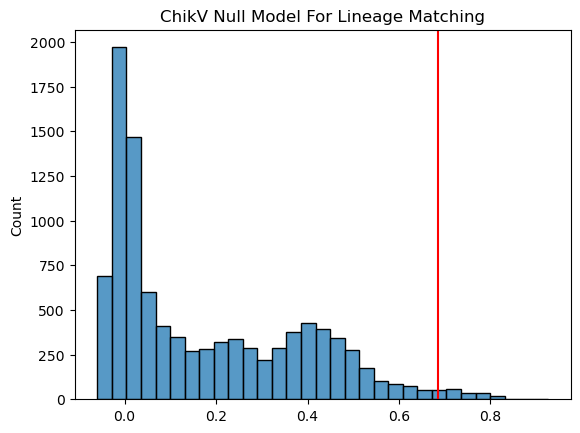

In [7]:
true = ari(chikv_lin.lineage,chikv_lin['GRI Lineage Level 0'])
sns.histplot(null)
plt.axvline(true,color='red')
plt.title("ChikV Null Model For Lineage Matching")
print("ARI:", true, "p-value: ", 1-(pos(null,true)/100))

Our CHIKV lineages are more significantly more closely aligned to the true labels than we would expect for an equivalent number of randomly generated lineage labels.  

We now apply this procedure to the VEE metadata.

In [8]:
vee_lin = pd.read_csv("VEE_metadata.tsv",sep='\t')
vee_lin

,strain,subtype,autolin
0,U55362.2,ID_VEEV,A.0.0
1,U55360.2,IC_VEEV,A.0.0.0.1
2,U55350.2,IC_VEEV,A.0.2.0.1
3,U55347.2,IC_VEEV,A.0.2.0.0
4,U55345.2,IC_VEEV,A.0
...,...,...,...
160,AF075252.1,IE_VEEV,A
161,AF075251.1,II_EVEV,A
162,AF069903.1,IAB_VEEV,A.0.1.0.1
163,AF004459.2,IC_VEEV,A.0.0.0.1


The VEE metadata file, instead of having several columns, has a single column representing the latest annotations only. We split this up programatically to generate levels equivalent to the columns for CHIKV.

In [9]:
vee_maxlevels = vee_lin.autolin.apply(lambda x:x.count(".")+1).max()
ari_level_match = []
for l in range(vee_maxlevels):
    vee_lin['level_' + str(l)] = vee_lin.autolin.apply(lambda x:".".join(x.split(".")[:l]))
    ariv = ari(vee_lin.subtype,vee_lin['level_'+str(l)])
    print(ariv)
    ari_level_match.append(ariv)
vee_lin

0.0
0.17987609509415267
0.3388505654355322
0.1403158040017794
0.06609482391169617
0.05624949712524545


,strain,subtype,autolin,level_0,level_1,level_2,level_3,level_4,level_5
0,U55362.2,ID_VEEV,A.0.0,,A,A.0,A.0.0,A.0.0,A.0.0
1,U55360.2,IC_VEEV,A.0.0.0.1,,A,A.0,A.0.0,A.0.0.0,A.0.0.0.1
2,U55350.2,IC_VEEV,A.0.2.0.1,,A,A.0,A.0.2,A.0.2.0,A.0.2.0.1
3,U55347.2,IC_VEEV,A.0.2.0.0,,A,A.0,A.0.2,A.0.2.0,A.0.2.0.0
4,U55345.2,IC_VEEV,A.0,,A,A.0,A.0,A.0,A.0
...,...,...,...,...,...,...,...,...,...
160,AF075252.1,IE_VEEV,A,,A,A,A,A,A
161,AF075251.1,II_EVEV,A,,A,A,A,A,A
162,AF069903.1,IAB_VEEV,A.0.1.0.1,,A,A.0,A.0.1,A.0.1.0,A.0.1.0.1
163,AF004459.2,IC_VEEV,A.0.0.0.1,,A,A.0,A.0.0,A.0.0.0,A.0.0.0.1


Text(0.5, 1.0, 'VEE Level ARI')

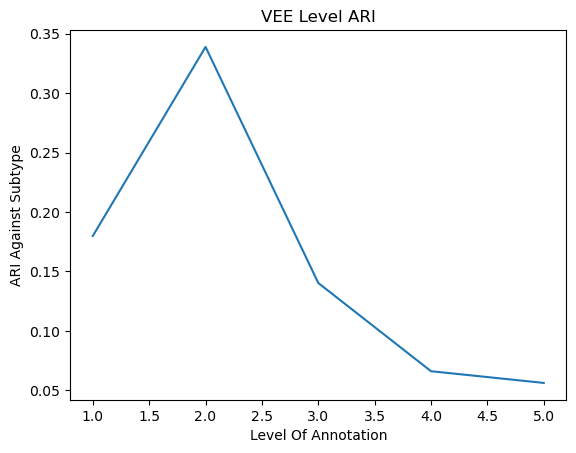

In [10]:
sns.lineplot(x=range(1,vee_maxlevels),y=ari_level_match[1:])
plt.ylabel("ARI Against Subtype")
plt.xlabel("Level Of Annotation")
plt.title("VEE Level ARI")

For VEE, the second level has the best overall alignment with subtypes, but it's still rather poor with only 0.35. 

VEE is more complex than CHIKV in that it constitutes multiple distinct viruses. VEEV subtypes behave somewhat different from non-VEEV subtypes. VEEV subtypes are based in serology and are not monophyletic, making them much more difficult to capture with monophyletic clades. Our first level of annotation immediately splits VEEV off from the rest of VEE, but our second level is less successful at recapitulating these paraphyletic subtypes. 

To approach this, we divide the subtypes column into two subtype columns, one representing VEEV versus other VEE lineages, and the other representing the various VEEV subtypes. We then compare the first level of annotation to this first column, and the second level to the second column.

In [11]:
vee_lin['VEEV'] = vee_lin.subtype.apply(lambda x:"VEEV" in x)
vee_lin.VEEV.value_counts()

True     142
False     23
Name: VEEV, dtype: int64

In [12]:
def veev_subt(subt):
    if 'VEEV' in subt:
        return subt
    else:
        return "not VEEV"
vee_lin['VEEV_subtype'] = vee_lin.subtype.apply(veev_subt)
vee_lin['VEE_subtype'] = vee_lin.subtype.apply(lambda x:x if "VEEV" not in x else "VEEV")
vee_lin

,strain,subtype,autolin,level_0,level_1,level_2,level_3,level_4,level_5,VEEV,VEEV_subtype,VEE_subtype
0,U55362.2,ID_VEEV,A.0.0,,A,A.0,A.0.0,A.0.0,A.0.0,True,ID_VEEV,VEEV
1,U55360.2,IC_VEEV,A.0.0.0.1,,A,A.0,A.0.0,A.0.0.0,A.0.0.0.1,True,IC_VEEV,VEEV
2,U55350.2,IC_VEEV,A.0.2.0.1,,A,A.0,A.0.2,A.0.2.0,A.0.2.0.1,True,IC_VEEV,VEEV
3,U55347.2,IC_VEEV,A.0.2.0.0,,A,A.0,A.0.2,A.0.2.0,A.0.2.0.0,True,IC_VEEV,VEEV
4,U55345.2,IC_VEEV,A.0,,A,A.0,A.0,A.0,A.0,True,IC_VEEV,VEEV
...,...,...,...,...,...,...,...,...,...,...,...,...
160,AF075252.1,IE_VEEV,A,,A,A,A,A,A,True,IE_VEEV,VEEV
161,AF075251.1,II_EVEV,A,,A,A,A,A,A,False,not VEEV,II_EVEV
162,AF069903.1,IAB_VEEV,A.0.1.0.1,,A,A.0,A.0.1,A.0.1.0,A.0.1.0.1,True,IAB_VEEV,VEEV
163,AF004459.2,IC_VEEV,A.0.0.0.1,,A,A.0,A.0.0,A.0.0.0,A.0.0.0.1,True,IC_VEEV,VEEV


ARI: 0.8992437260641905 p-value:  0.00029999999999996696


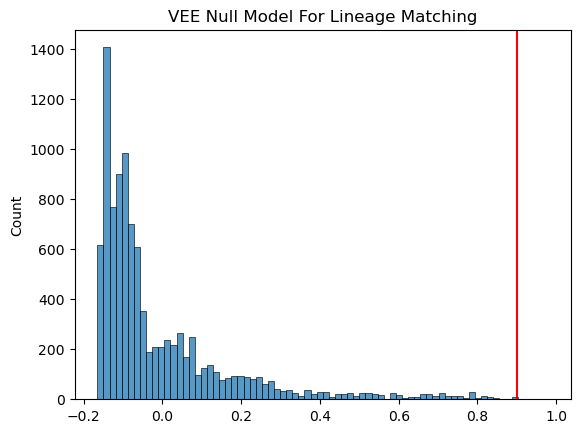

In [13]:
vee_null = sample_ari(vee, vee_lin, target='level_1',truename='VEE_subtype')
true = ari(vee_lin.VEE_subtype,vee_lin.level_1)
sns.histplot(vee_null)
plt.axvline(true,color='red')
plt.title("VEE Null Model For Lineage Matching")
print("ARI:", true, "p-value: ", 1-(pos(vee_null,true)/100))

Our method effectively partitions VEEV from the rest of VEE, compared to random expectations.

Extracting subtree of 142 samples.
Completed in 10 msec 

Finished 'subtree' in 0.0107 seconds


ARI: 0.27902608877877666 p-value:  0.24930000000000008


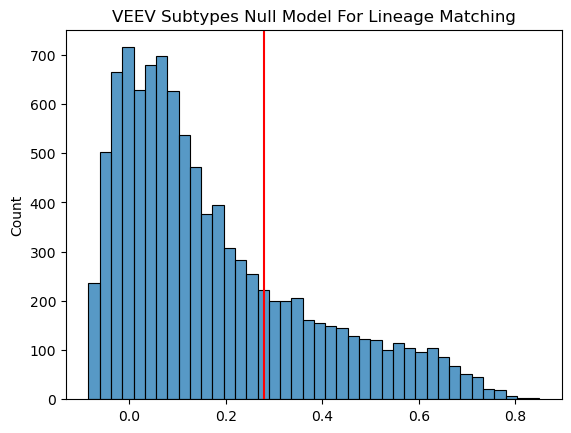

In [15]:
veev_lin = vee_lin[vee_lin['VEEV']]
veev = vee.subtree(vee_lin[vee_lin['VEEV']].strain)
veev_null = sample_ari(veev, veev_lin, target='level_2',truename='VEEV_subtype')
true = ari(veev_lin.VEEV_subtype,veev_lin.level_2)
sns.histplot(veev_null)
plt.axvline(true,color='red')
plt.title("VEEV Subtypes Null Model For Lineage Matching")
print("ARI:", true, "p-value: ", 1-(pos(veev_null,true)/100))


However, it fails to recapitulate VEEV subtypes on the second level. This is primarily because VEEV subtypes are paraphyletic serotypes, not monophyletic lineages, and so to some extent impossible to replicate with a monophyletic system.